In [47]:
import complexity as cp
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from numba import jit
from itertools import combinations
import tarfile as tar

csv_header = "solution_fitness;trial;fitness;bot_id;sensor_tuples;motor_values".split(";")

In [48]:
def compute_complexity_measure(filename: str, trials: int) -> pd.DataFrame:
    df = pd.read_csv(filename, ";", skiprows=1, index_col=False, names=csv_header)

    shannon = [compute_shannon_entropy(df, trial) for trial in np.arange(0, trials, 1)]
    mi = [compute_mutual_info(df, trial) for trial in np.arange(0, trials, 1)]

    df.drop(["sensor_tuples", "motor_values", "bot_id"], axis=1, inplace=True)
    output = df.groupby(["trial"]).first()

    output["entropy"] = shannon
    output["mutual_info"] = mi

    return output


def compute_shannon_entropy(df: pd.DataFrame, trial: int) -> float:
    trial_x = df[df["trial"] == trial]
    shannon_entropies = trial_x["sensor_tuples"]\
        .apply(lambda values: cp.sensor_tuples_to_string(ast.literal_eval(values)))\
        .apply(lambda values: cp.shannon(values))

    return np.mean(shannon_entropies)


## compute the mutual info from dataframe of specific trial
## returns a table with [trial, solution_fitness, fitness, bot_id, mutual_info]
def compute_mutual_info(df: pd.DataFrame, trial: int) -> float:
    trial_x = df[df["trial"] == trial]
    trial_x.reset_index(drop=True, inplace=True)
    pairs = list(combinations(np.arange(0, len(trial_x["bot_id"]), 1), 2))

    mi = []
    for (xi, yi) in pairs:
        x = trial_x.loc[xi]["motor_values"]
        y = trial_x.loc[yi]["motor_values"]
        mi.append(cp.mutual_info(x, y))

    return np.mean(mi)

In [55]:
def extract_tgz(filename: str, basename: str):
    import os.path as path
    target_folder = path.join(path.dirname(filename), "temp")
    tar = tarfile.open(filename, "r:gz")
    tar.extractall(path=target_folder)
    tar.close()
    return path.join(target_folder, basename)

def create_bar_plot(basename: str, configurations: int, trials: int):
    index = np.arange(0, configurations, 1)

    avg_best = [compute_complexity_measure(f"{basename}_best_{i}.csv", trials).mean() for i in index]
    avg_middle = [compute_complexity_measure(f"{basename}_middle_{i}.csv", trials).mean() for i in index]
    avg_worst = [compute_complexity_measure(f"{basename}_worst_{i}.csv", trials).mean() for i in index]

    def create_dataframe(best, middle, worst, mapping):
        return pd.DataFrame({ 'best' : list(map(mapping, best)), 
                       'middle' : list(map(mapping, middle)), 
                       'worst' : list(map(mapping, worst))}, index=index)
    
    df_entropy = create_dataframe(avg_best, avg_middle, avg_worst, lambda x: x["entropy"])
    df_mi = create_dataframe(avg_best, avg_middle, avg_worst, lambda x: x["mutual_info"])
    
    fig, axes = plt.subplots(nrows=2, ncols=1)
    
    ax1 = df_entropy.plot.bar(ax=axes[0], rot=0, figsize=(15, 8))
    ax2 = df_mi.plot.bar(ax=axes[1], rot=0, figsize=(15, 8))

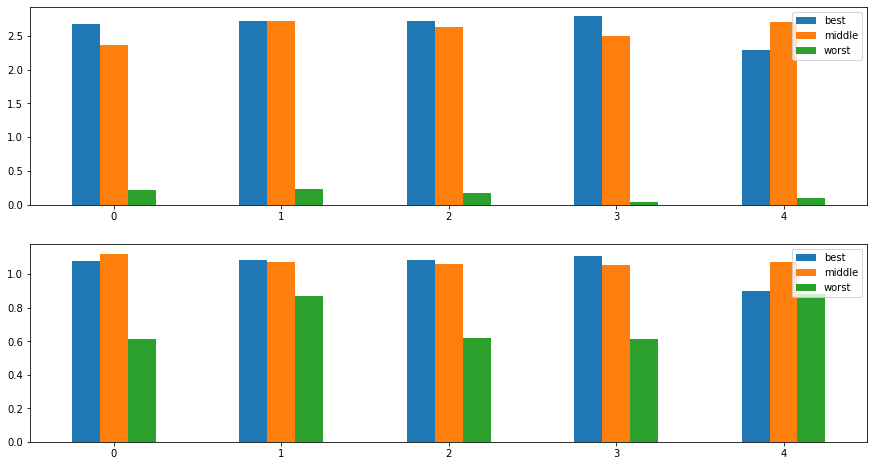

In [56]:
statistics_folder = r'c:/users/andrea petreti/documents/tesi_robotics/statistics/complexity/task1/'
create_bar_plot(statistics_folder + "task1_bis", 5, 10)

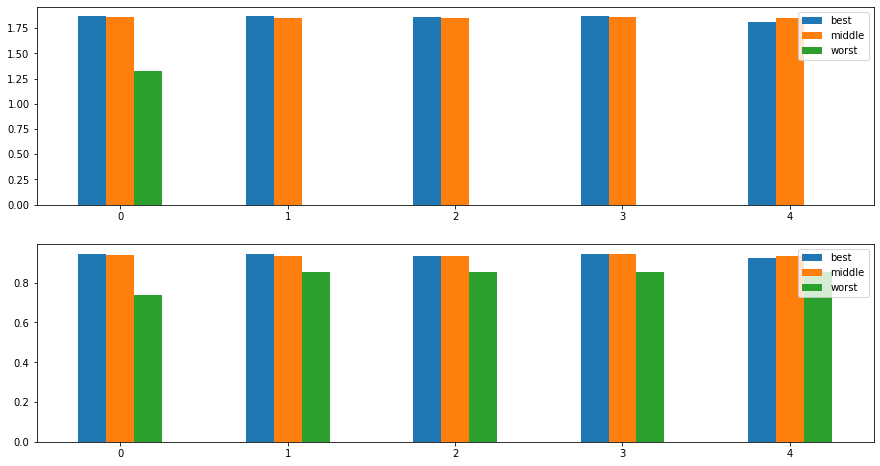

In [76]:
statistics_folder = r'c:/users/andrea petreti/documents/tesi_robotics/statistics/complexity/task2/'
create_bar_plot(extract_tgz(statistics_folder + 'task2_11-15_29-01.tgz', 'task2'), 5, 10)